# Introdução

Você foi alocado(a) em um time da *Indicium* que está trabalhando atualmente junto a um cliente no processo de criação de uma plataforma de aluguéis temporários na cidade de Nova York. Para o desenvolvimento de sua estratégia de precificação, pediu para que a *Indicium* fizesse uma análise exploratória dos dados de seu maior concorrente, assim como um teste de validação de um modelo preditivo.

**Seu objetivo é desenvolver um modelo de previsão de preços a partir do dataset oferecido, e avaliar tal modelo utilizando as métricas de avaliação que mais fazem sentido para o problema**. O uso de outras fontes de dados além do dataset é permitido (e encorajado). Você poderá encontrar em anexo um dicionário dos dados.


# Carregando bibliotecas

In [3]:
# Manipulação dos dados
import pandas as pd
import numpy as np 
from collections import Counter
from tabulate import tabulate

# Análise exploratória
# Geração de gráficos
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
import seaborn as sns

# Criação de mapas
import folium

# Processamento de lingugagem natural
# Importando um conjunto de stopwords da língua inglesa
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Feature engineering
from geopy.distance import geodesic

# Modelagem
# Função estatística para medir assimetria
from scipy.stats import skew

# Funções para dividir em treino e teste e para construção da validação cruzada
from sklearn.model_selection import train_test_split, KFold

# Função de feature importance
from sklearn.inspection import permutation_importance

# Cálculo das métricas de performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Modelos que serão utilizados
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Imputers e o pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Importando a função para tratar variáveis categóricas
from category_encoders import CatBoostEncoder

# Tunagem de hiperparâmetros
import optuna as opt

# Exportação do modelo
import pickle

# Configurações gerais
# Ignorar avisos
import warnings
warnings.filterwarnings('ignore')

# Configurações do Matplotlib
plt.style.use('ggplot')
%matplotlib inline

# Definir exibição máxima de linhas e colunas no Pandas
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

# Quebras e espaçamentos automáticos
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pschm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<IPython.core.display.Javascript object>

# Importação, análise e tratamentos iniciais

## Importação dos dados

In [4]:
df = pd.read_csv('teste_indicium_precificacao.csv')

df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


<IPython.core.display.Javascript object>

## Análise de informações gerais do dataset

In [5]:
print(f'A tabela possui {df.shape[1]} colunas e {df.shape[0]} linhas.')

A tabela possui 16 colunas e 48894 linhas.


<IPython.core.display.Javascript object>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

<IPython.core.display.Javascript object>

Grande parte das colunas não possui valores nulos, com exceção de *nome*, *host_name*, *ultima_review* e *reviews_por_mes*. Nas duas últimas não há necessidade de averiguarmos a fundo, visto que alguns anúncios podem realmente não conter avaliações. No entanto, *nome* e *host_name* devem ser tratadas, pois são valores imprescindíveis em um anúncio. 

Os tipos de dados também estão em sua maioria corretos. Apenas a coluna *ultima_review* que deve ser transformado para o tipo data.

## Tratamento de valores nulos

Vamos substituir, nas colunas *nome* e *host_name*, os valores nulos por "Sem informação", a coluna *reviews_por_mes* por zero e *ultima_review* será convertida para o tipo data e, por motivos de compatibilidade com alguns algoritmos durante a modelagem preditiva, será convertida em "Unix Timestamps".

In [7]:
df1 = df.copy()
df1['nome'].fillna('Sem informação', inplace=True)
df1['host_name'].fillna('Sem informação', inplace=True)
df1['reviews_por_mes'].fillna(0, inplace=True)
df1['ultima_review'] = pd.to_datetime(df['ultima_review'], errors='coerce')
df1['ultima_review'] = df1['ultima_review'].astype('int64') // 10**9
df1.isnull().sum()

id                               0
nome                             0
host_id                          0
host_name                        0
bairro_group                     0
bairro                           0
latitude                         0
longitude                        0
room_type                        0
price                            0
minimo_noites                    0
numero_de_reviews                0
ultima_review                    0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64

<IPython.core.display.Javascript object>

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48894 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48894 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  48894 non-null 

<IPython.core.display.Javascript object>

## Composição da tabela

In [9]:
numericas = df1.select_dtypes(include=np.number)
nao_numericas = df1.select_dtypes(exclude=np.number)

print(f'A tabela contém {numericas.shape[1]} colunas numéricas e {nao_numericas.shape[1]} colunas não numéricas.')

A tabela contém 11 colunas numéricas e 5 colunas não numéricas.


<IPython.core.display.Javascript object>

Valores únicos em cada coluna:

In [10]:
df1.nunique().sort_values()

room_type                            3
bairro_group                         5
calculado_host_listings_count       47
minimo_noites                      109
bairro                             221
disponibilidade_365                366
numero_de_reviews                  394
price                              674
reviews_por_mes                    938
ultima_review                     1765
host_name                        11453
longitude                        14718
latitude                         19048
host_id                          37457
nome                             47905
id                               48894
dtype: int64

<IPython.core.display.Javascript object>

Verificando se não existem linhas duplicadas:

In [11]:
df1.duplicated().sum()

0

<IPython.core.display.Javascript object>

Perfeito! Nenhuma linha duplicada!

# Análise exploratória dos dados

### Preços

Olhando de forma mais ampla, vamos analisar os preços:

In [12]:
descricao = df1['price'].describe()
descricao['var'] = df1['price'].var()
descricao['kurt'] = df1['price'].kurtosis()
descricao = pd.DataFrame(descricao)
print(tabulate(descricao, headers='keys', tablefmt='psql', showindex=True))

+-------+-----------+
|       |     price |
|-------+-----------|
| count | 48894     |
| mean  |   152.721 |
| std   |   240.157 |
| min   |     0     |
| 25%   |    69     |
| 50%   |   106     |
| 75%   |   175     |
| max   | 10000     |
| var   | 57675.2   |
| kurt  |   585.661 |
+-------+-----------+


<IPython.core.display.Javascript object>

Baseado na tabela montada acima, podemos observar que o **preço médio** por noite em um apartamento de Nova York é de aproximadamente **U\$ 152,72**. No entanto, o **desvio padrão de U\$ 240,16** nos remete a uma variação enorme entre os preços apresentados.

A **mediana é igual a U\$ 106,00**, bem menor que a média, isso quer dizer que temos dados muito desbalanceados para a direita. O altíssimo valor da curtose (585,661) confirma essa distribuição assimétrica para o lado direito, indicando outliers de preços bem acima da mediana.

Os quartis superior e inferior nos mostram que a maior parte dos preços estão **entre U$ 69,00 e U\$ 175,00**.

A presença de preços iguais a zero também já nos acende um alerta em alguma incompatibilidade nos dados, visto que seria impraticável a presença de um anúncio assim.

Não é muito provável um anúncio com preço igual a zero, não é mesmo? Vamos analisar.

In [13]:
anuncios_preco_zero = df1[df1['price'] == 0]
display(anuncios_preco_zero.head())

print()
print()
print(f'Foram encontrados {len(anuncios_preco_zero)} anúncios com preço igual a zero.')

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
23160,18750597,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Kimberly,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,4,1,1515196800,0.05,4,28
25432,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,1561334400,2.56,4,127
25633,20523843,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",15787004,Martial Loft,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,1558137600,0.71,5,0
25752,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,1509062400,0.53,2,0
25777,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,1514851200,0.15,1,73




Foram encontrados 11 anúncios com preço igual a zero.


<IPython.core.display.Javascript object>

Vamos solucionar esse problema removendo essas linhas, para não interferir em nossa análise.

In [14]:
df2 = df1.copy()
df2 = df1.loc[df1['price'] != 0]

<IPython.core.display.Javascript object>

In [15]:
media = df2['price'].mean()
media_formatada = ('U$ {:,.2f}'.format(media).replace(',', 'v').replace('.', ',').replace('v', '.'))

precos_outliers_sup = df2.query(f'price >= 5000')

print(f'''Além disso, também possuímos alguns outliers superiores. Considerando que a média de preços por anúncio é de {media_formatada}, valores muito altos podem acender um alerta. Por exemplo, na tabela, temos {len(precos_outliers_sup)} anúncios com preços iguais ou superiores a U$ 5.000.''')

print()

display(precos_outliers_sup.sample(5))


Além disso, também possuímos alguns outliers superiores. Considerando que a média de preços por anúncio é de U$ 152,76, valores muito altos podem acender um alerta. Por exemplo, na tabela, temos 26 anúncios com preços iguais ou superiores a U$ 5.000.



,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
29237,22436899,1-BR Lincoln Center,72390391,Jelena,Manhattan,Upper West Side,40.77213,-73.98665,Entire home/apt,10000,30,0,-9223372037,0.00,1,83
3536,2110145,UWS 1BR w/backyard + block from CP,2151325,Jay And Liz,Manhattan,Upper West Side,40.77782,-73.97848,Entire home/apt,6000,14,17,1424131200,0.27,1,359
30267,23377410,Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho,18128455,Rum,Manhattan,Tribeca,40.72197,-74.00633,Entire home/apt,8500,30,2,1537228800,0.18,1,251
9150,7003697,Furnished room in Astoria apartment,20582832,Kathrine,Queens,Astoria,40.76810,-73.91651,Private room,10000,100,2,1455321600,0.04,1,0
4344,2919330,NearWilliamsburg bridge 11211 BK,14908606,Bianca,Brooklyn,Bedford-Stuyvesant,40.69572,-73.95731,Private room,5000,6,10,1451692800,0.16,1,363


<IPython.core.display.Javascript object>

O procedimento correto seria recorrer a pessoa ou equipe responsável pela coleta dos dados, para garantir a qualidade e fidedignidade dos dados. Como nesse caso isso não é possível, 
vamos considerar que sejam realmente anúncios de imóveis de alto padrão e mantê-los no dataset.

Agora que tratamos esses outliers, vamos retomar nossa análise de preços:

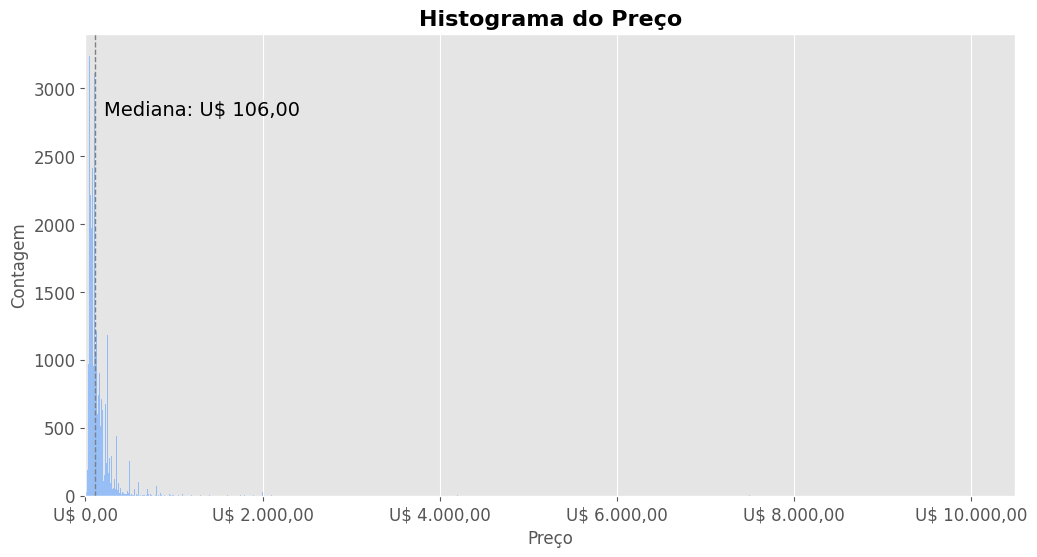

<IPython.core.display.Javascript object>

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
mediana = df2.price.median()
mediana_format = ('U$ {:,.2f}'.format(mediana).replace(',', 'v').replace('.', ',').replace('v', '.'))

sns.histplot(df2.price, color='#73ACFF')
plt.axvline(mediana, color='grey', linestyle='dashed', linewidth=1)
plt.title('Histograma do Preço', fontsize=16, fontweight='bold')
plt.xlabel('Preço', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
formatter = mtick.FuncFormatter(lambda x, _: 'U$ {:,.2f}'.format(x).replace(',', 'v').replace('.', ',').replace('v', '.'))
ax.xaxis.set_major_formatter(formatter)
ax.grid(False, axis='y')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0)
plt.text(x=df2.price.median()+100, y=2800, s=f'Mediana: {mediana_format}', fontsize=14)
plt.show();

### Bairros

Como os anúncios estão distribuidos por bairro?

A plataforma possui anúncios em 5 bairros diferentes, sendo eles:
Manhattan, com 44.3% dos anúncios
Brooklyn, com 41.1% dos anúncios
Queens, com 11.6% dos anúncios
Staten Island, com 0.8% dos anúncios
Bronx, com 2.2% dos anúncios


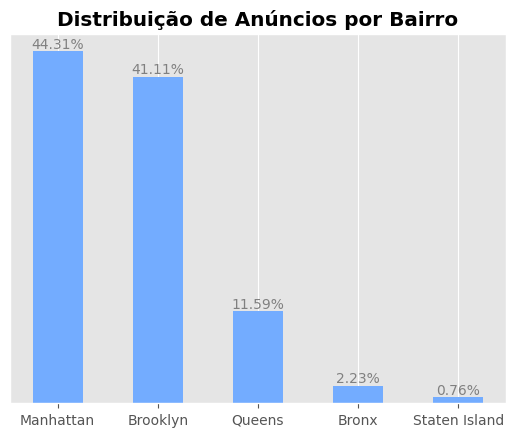

<IPython.core.display.Javascript object>

In [17]:
quantidade_bairros = len(df2.bairro_group.unique())

print(f'A plataforma possui anúncios em {quantidade_bairros} bairros diferentes, sendo eles:')
for bairro in df2.bairro_group.unique():
    percentual_ocorrencia = round(len(df2[df2['bairro_group']==bairro])/len(df2)*100, 1)
    print(f'{bairro}, com {percentual_ocorrencia}% dos anúncios')

fig, ax = plt.subplots()


x = df2.bairro_group.value_counts().keys()
y = df2.bairro_group.value_counts(normalize=True)

barra = ax.bar(x, y, width=0.5, color='#73ACFF')

plt.title('Distribuição de Anúncios por Bairro', fontweight='bold')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))

ax.set_xticks(np.arange(len(x)))
plt.gca().get_yaxis().set_visible(False)
ax.set_xticklabels(tuple(x), ha='center')
ax.bar_label(barra, labels=[f'{i*100:.2f}%' for i in y.values], color='grey')

plt.show();

Agora, vamos analisar como o preço está distribuido em cada bairro:

,count,mean,std,min,25%,50%,75%,max
bairro_group,,,,,,,,
Manhattan,21660.0,196.88,291.39,10.0,95.0,150.0,220.0,10000.0
Brooklyn,20094.0,124.44,186.90,10.0,60.0,90.0,150.0,10000.0
Staten Island,373.0,114.81,277.62,13.0,50.0,75.0,110.0,5000.0
Queens,5666.0,99.52,167.10,10.0,50.0,75.0,110.0,10000.0
Bronx,1090.0,87.58,106.73,10.0,45.0,65.0,99.0,2500.0


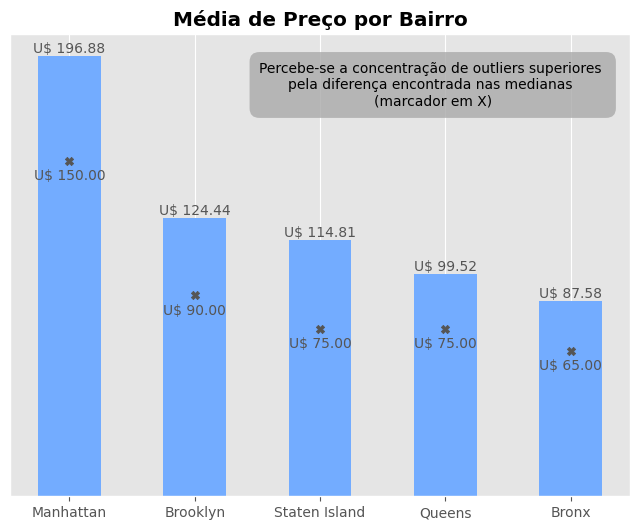

<IPython.core.display.Javascript object>

In [18]:
preco_bairro = df2.groupby('bairro_group')['price'].describe().round(2).sort_values(by='mean', ascending=False)
display(preco_bairro)

fig, ax = plt.subplots(figsize=(8,6))

x = preco_bairro.index
y = preco_bairro['mean']

barra = ax.bar(x, y, width=0.5, color='#73ACFF')

medianas = preco_bairro['50%']
ax.scatter(x, medianas, marker='X', color='#555555', zorder=3)
for i, v in enumerate(medianas):
    ax.text(i, v-10, f'U$ {v:.2f}', ha='center', va='bottom', color='#555555')

plt.title('Média de Preço por Bairro', fontweight='bold')
plt.gca().get_yaxis().set_visible(False)

ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(tuple(x), ha='center')
ax.bar_label(barra, labels=[f'U$ {i:.2f}' for i in y.values], color='#555555')
ax.text(2.9, 175, 'Percebe-se a concentração de outliers superiores \npela diferença encontrada nas medianas \n(marcador em X)', 
        bbox={'facecolor': 'darkgrey', 'alpha':0.8, 'pad': 0.7, 'edgecolor': 'none', 'boxstyle': 'round'}, ha='center')

plt.show();

Vamos abrir em uma visão geral sobre como as colunas numéricas se comportam de acordo com os bairros:

In [19]:
agg_func = {
    'price':['min', 'median', 'mean', 'std', skew],
    'minimo_noites':['min', 'median', 'mean', 'std', skew],
    'numero_de_reviews':['min', 'median', 'mean', 'std', skew],
    'reviews_por_mes':['min', 'median', 'mean', 'std', skew],
    'calculado_host_listings_count':['min', 'median', 'mean', 'std', skew]
}

df2.groupby('bairro_group').agg(agg_func)

price                                           minimo_noites  \
                min median        mean         std       skew           min   
bairro_group                                                                  
Bronx            10   65.0   87.577064  106.725371  12.493704             1   
Brooklyn         10   90.0  124.437693  186.901408  23.465343             1   
Manhattan        10  150.0  196.884903  291.386838  15.946238             1   
Queens           10   75.0   99.517649  167.102155  39.151557             1   
Staten Island    13   75.0  114.812332  277.620403  15.031420             1   

                                                     numero_de_reviews         \
              median      mean        std       skew               min median   
bairro_group                                                                    
Bronx            2.0  4.563303  15.638775  14.324931                 0    9.0   
Brooklyn         3.0  6.055738  17.635297  20.629041                 0    6.0   
Manhattan        3.0  8.579409  24.051383  21.366054                 0    4.0   
Queens           2.0  5.181433  15.028725  18.712365                 0    7.0   
Staten Island    2.0  4.831099  19.727605  16.484032                 0   12.0   

                                              reviews_por_mes         \
                    mean        std      skew             min median   
bairro_group                                                           
Bronx          25.977982  42.225003  2.935565             0.0   0.87   
Brooklyn       24.198417  44.346333  3.260489             0.0   0.38   
Manhattan      20.986565  42.573021  3.892750             0.0   0.28   
Queens         27.700318  51.955853  4.196021             0.0   0.76   
Staten Island  30.941019  44.830766  2.523924             0.0   1.00   

                                            calculado_host_listings_count  \
                   mean       std      skew                           min   
bairro_group                                                                
Bronx          1.474661  1.668538  1.463106                             1   
Brooklyn       1.049565  1.457772  2.078369                             1   
Manhattan      0.976827  1.524539  4.682136                             1   
Queens         1.567076  2.130754  2.525402                             1   
Staten Island  1.576381  1.690710  1.744826                             1   

                                                       
              median       mean        std       skew  
bairro_group                                           
Bronx            1.0   2.232110   2.371060   4.788701  
Brooklyn         1.0   2.283119   5.274623  14.787126  
Manhattan        1.0  12.791874  48.235813   5.314480  
Queens           1.0   4.060184  12.445003   7.168930  
Staten Island    1.0   2.319035   1.915580   1.544199

<IPython.core.display.Javascript object>

Alguns pontos que valem ser destacados:
* **Manhattan** possui a maior média de preço e mínimo de noites, mas o que mais chama a atenção é a disparidade na **média de anúncios pelo mesmo anfitrião**. Pode ser averiguado se não está ocorrendo uma espécie de oligopólio dos imóveis do bairro por um grupo de anfitriões.
* Quase todas as variáveis possuem características de **presença de outliers**.
* Os **preços em Queens** possui um **"skew"** bem mais alto que os demais, praticamente o dobro de todos os outros, que também são altos. Isso quer dizer que sua **distribuição de preços está muito assimétrica para a direita**, devido a um grande número de outliers.

Vamos expandir a análise e observar as áreas de cada bairro. Chamaremos de distritos.

São 221 distritos presentes no DataFrame. Vamos observar aqueles com a maior quantidade de anúncios: 


,Bairro,Distrito,Quantidade
0,Brooklyn,Williamsburg,3919
1,Brooklyn,Bedford-Stuyvesant,3710
2,Manhattan,Harlem,2658
3,Brooklyn,Bushwick,2462
4,Manhattan,Upper West Side,1971
5,Manhattan,Hell's Kitchen,1958
6,Manhattan,East Village,1853
7,Manhattan,Upper East Side,1798
8,Brooklyn,Crown Heights,1564
9,Manhattan,Midtown,1545


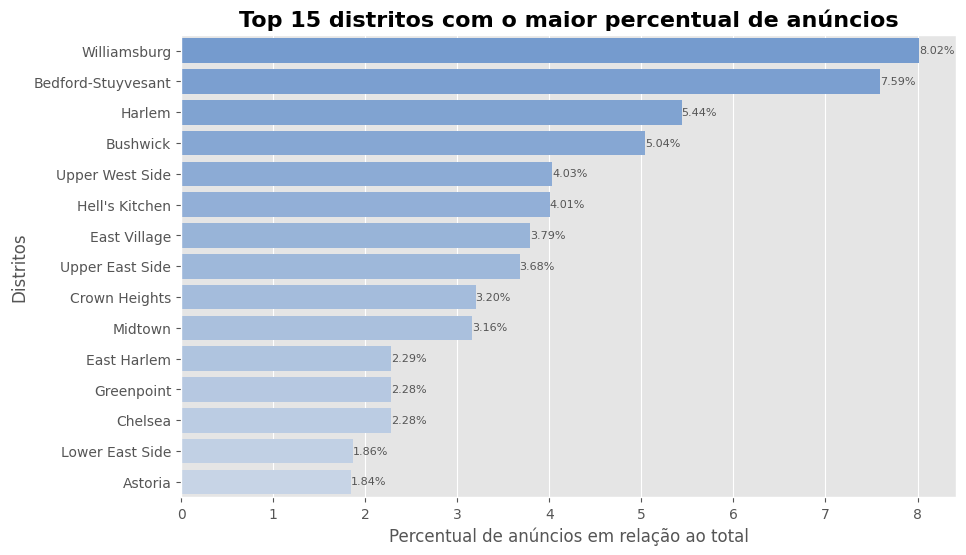

<IPython.core.display.Javascript object>

In [20]:
numero_distritos = len(df2['bairro'].unique())
print(f'São {numero_distritos} distritos presentes no DataFrame. Vamos observar aqueles com a maior quantidade de anúncios: ')

top_distritos = df2.groupby('bairro').size().sort_values(ascending=False).reset_index(name='Quantidade')[:15]

for index, bairro in top_distritos['bairro'].items():
    top_distritos.loc[index, 'Bairro'] = df2['bairro_group'].loc[df2['bairro'] == bairro].iloc[0]
    
top_distritos = top_distritos.reindex(columns=['Bairro', 'bairro', 'Quantidade'])
top_distritos.columns = ['Bairro', 'Distrito', 'Quantidade']
top_distritos_percentual = top_distritos['Quantidade']/len(df2)*100
display(top_distritos)

fig, ax = plt.subplots(figsize=(10,6))

ax = sns.barplot(data=top_distritos, x=top_distritos_percentual, y='Distrito', palette = sns.light_palette("#69d", 22, reverse=True))
# ax.bar_label(ax.containers[0], fmt='%.2f%%', fontsize=8)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', fontsize=8, color='#555555')

plt.title('Top 15 distritos com o maior percentual de anúncios', fontsize=16, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Percentual de anúncios em relação ao total', fontsize=12)
plt.ylabel('Distritos', fontsize=12)
plt.show();


### Análise de geolocalização

Vamos analisar, no mapa, como estão distribuídos os anúncios mais caros.

In [21]:
sample = df2.query('price > 2000')
centro_ny_coordenadas = [40.7128, -74.0060]

mapa = folium.Map(location=centro_ny_coordenadas, zoom_start=12)
folium.Marker(centro_ny_coordenadas, tooltip='Centro de Nova York', icon=folium.Icon(color='red', icon='glyphicon-home', prefix='glyphicon'), 
              icon_size=(30, 30)).add_to(mapa)

cores_bairros = {'Manhattan': 'darkblue', 'Brooklyn': 'green', 'Queens': 'orange', 'Staten Island': 'purple', 'Bronx': 'lightblue'}

for indice, linha in sample.iterrows():
    
    folium.Marker([linha['latitude'], linha['longitude']], tooltip=(f'Anúncio: {linha["nome"]} | Distrito: {linha["bairro"]} | Preço: {linha["price"]}'),
                  icon=folium.Icon(color=cores_bairros[linha['bairro_group']])).add_to(mapa)

mapa


<IPython.core.display.Javascript object>

Aqui, mostramos anúncios com preços superiores a U$ 2.000,00. A cor do marcador representa o bairro em que o anúncio se encontra, sendo:
* Azul-escuro: Manhattan;
* Verde: Brooklyn;
* Laranja: Queens;
* Azul-claro: Bronx;
* Roxo: Staten Island.

Obs.: Passando o mouse por cima do marcador, você verá informações como o nome, distrito e preço do anúncio.

### Anúncios por anfitrião

In [22]:
quantidade_hosts = len(df2.host_id.unique())
quantidade_imoveis = len(df2)
media_imoveis = round(quantidade_imoveis/quantidade_hosts,2)
host_mais_frequente = df2.host_id.value_counts().max()
host_menos_frequente = df2.host_id.value_counts().min()

print(f'''Estão cadastrados {quantidade_hosts} anfitriões, e cada um possui entre {host_menos_frequente} e {host_mais_frequente} imóveis.
No total, são {quantidade_imoveis} imóveis cadastrados, uma média de {media_imoveis} imóveis por anfitrião.''')

print()
print('A seguir, uma tabela com a faixa de valores de quantidade de anúncios por anfitrião:')

contagem_anuncios = df2['host_id'].value_counts()

df_contagem = pd.DataFrame({'host_id': contagem_anuncios.index, 'frequencia': contagem_anuncios.values})

faixas = [0, 2, 3, 6, 11, 21, 51, 101, float('inf')]
rotulos = ['1', '2', '3 a 5', '6 a 10', '11 a 20', '20 a 50', '51 a 100', '100+']

df_contagem['Anúncios'] = pd.cut(df_contagem['frequencia'], bins=faixas, labels=rotulos, right=False)

tabela_frequencia = df_contagem.groupby('Anúncios').size().reset_index(name='Quantidade')

display(tabela_frequencia)

Estão cadastrados 37455 anfitriões, e cada um possui entre 1 e 327 imóveis.
No total, são 48883 imóveis cadastrados, uma média de 1.31 imóveis por anfitrião.

A seguir, uma tabela com a faixa de valores de quantidade de anúncios por anfitrião:


,Anúncios,Quantidade
0,1,32302
1,2,3328
2,3 a 5,1483
3,6 a 10,248
4,11 a 20,56
5,20 a 50,27
6,51 a 100,7
7,100+,4


<IPython.core.display.Javascript object>

### Tipos de espaços

In [23]:
cores = {
    'Entire home/apt': '#440160',
    'Private room': '#482879',
    'Shared room': '#31688f'
}

fig = px.histogram(df2, x='room_type', color='room_type', color_discrete_map=cores)
fig.update_layout(title='Distribuição dos tipos de espaços',
                  xaxis_title='Tipo de espaço',
                  yaxis_title='Contagem')
fig.show()

<IPython.core.display.Javascript object>

In [24]:
preco_tipo = df2.groupby('room_type')['price'].describe().round(2).sort_values(by='mean', ascending=False)
display(preco_tipo)

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,25407.0,211.81,284.05,10.0,120.0,160.0,229.0,10000.0
Private room,22318.0,89.81,160.23,10.0,50.0,70.0,95.0,10000.0
Shared room,1158.0,70.25,101.77,10.0,33.0,45.0,75.0,1800.0


<IPython.core.display.Javascript object>

Observamos muitos anúncios para casas ou apartamentos inteiros e também para quartos privativos. Quartos compartilhados possuem pouquíssimos anúncios, algo que talvez possa ser investigado se é de fato pela baixa procura por esse tipo de acomodação ou por ser um nicho não tão explorado ainda.

### Boxplots de bairro e tipo de espaço

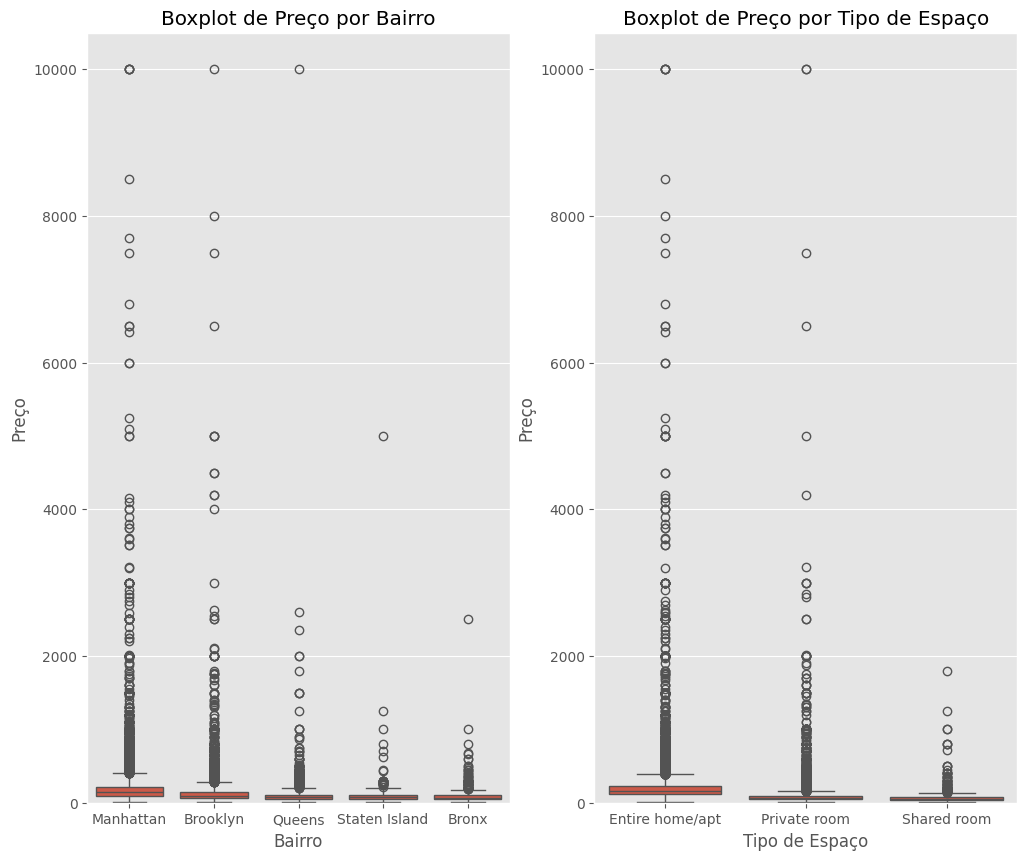

<IPython.core.display.Javascript object>

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10))

sns.boxplot(data=df2, x='bairro_group', y='price', ax=axes[0])
sns.boxplot(data=df2, x='room_type', y='price', ax=axes[1])

axes[0].set_xlabel('Bairro')
axes[0].set_ylabel('Preço')
axes[0].set_title('Boxplot de Preço por Bairro')
axes[0].set_ylim(0)

axes[1].set_xlabel('Tipo de Espaço')
axes[1].set_ylabel('Preço')
axes[1].set_title('Boxplot de Preço por Tipo de Espaço')
axes[1].set_ylim(0)
plt.show();

In [26]:
q1 = df2['price'].quantile(0.25)
q3 = df2['price'].quantile(0.75)
iqr = q3 - q1
limite_inf = q1 - 1.5 * iqr
limite_sup = q3 + 1.5 * iqr

outliers = df2['price'][df2['price'] < limite_inf] | df2['price'][df2['price'] > limite_sup]
porcentagem_outliers = len(outliers) / len(df2) * 100

print(f"Porcentagem de outliers: {round(porcentagem_outliers, 2)}%")



Porcentagem de outliers: 6.08%


<IPython.core.display.Javascript object>

### Analisando correlação de colunas numéricas

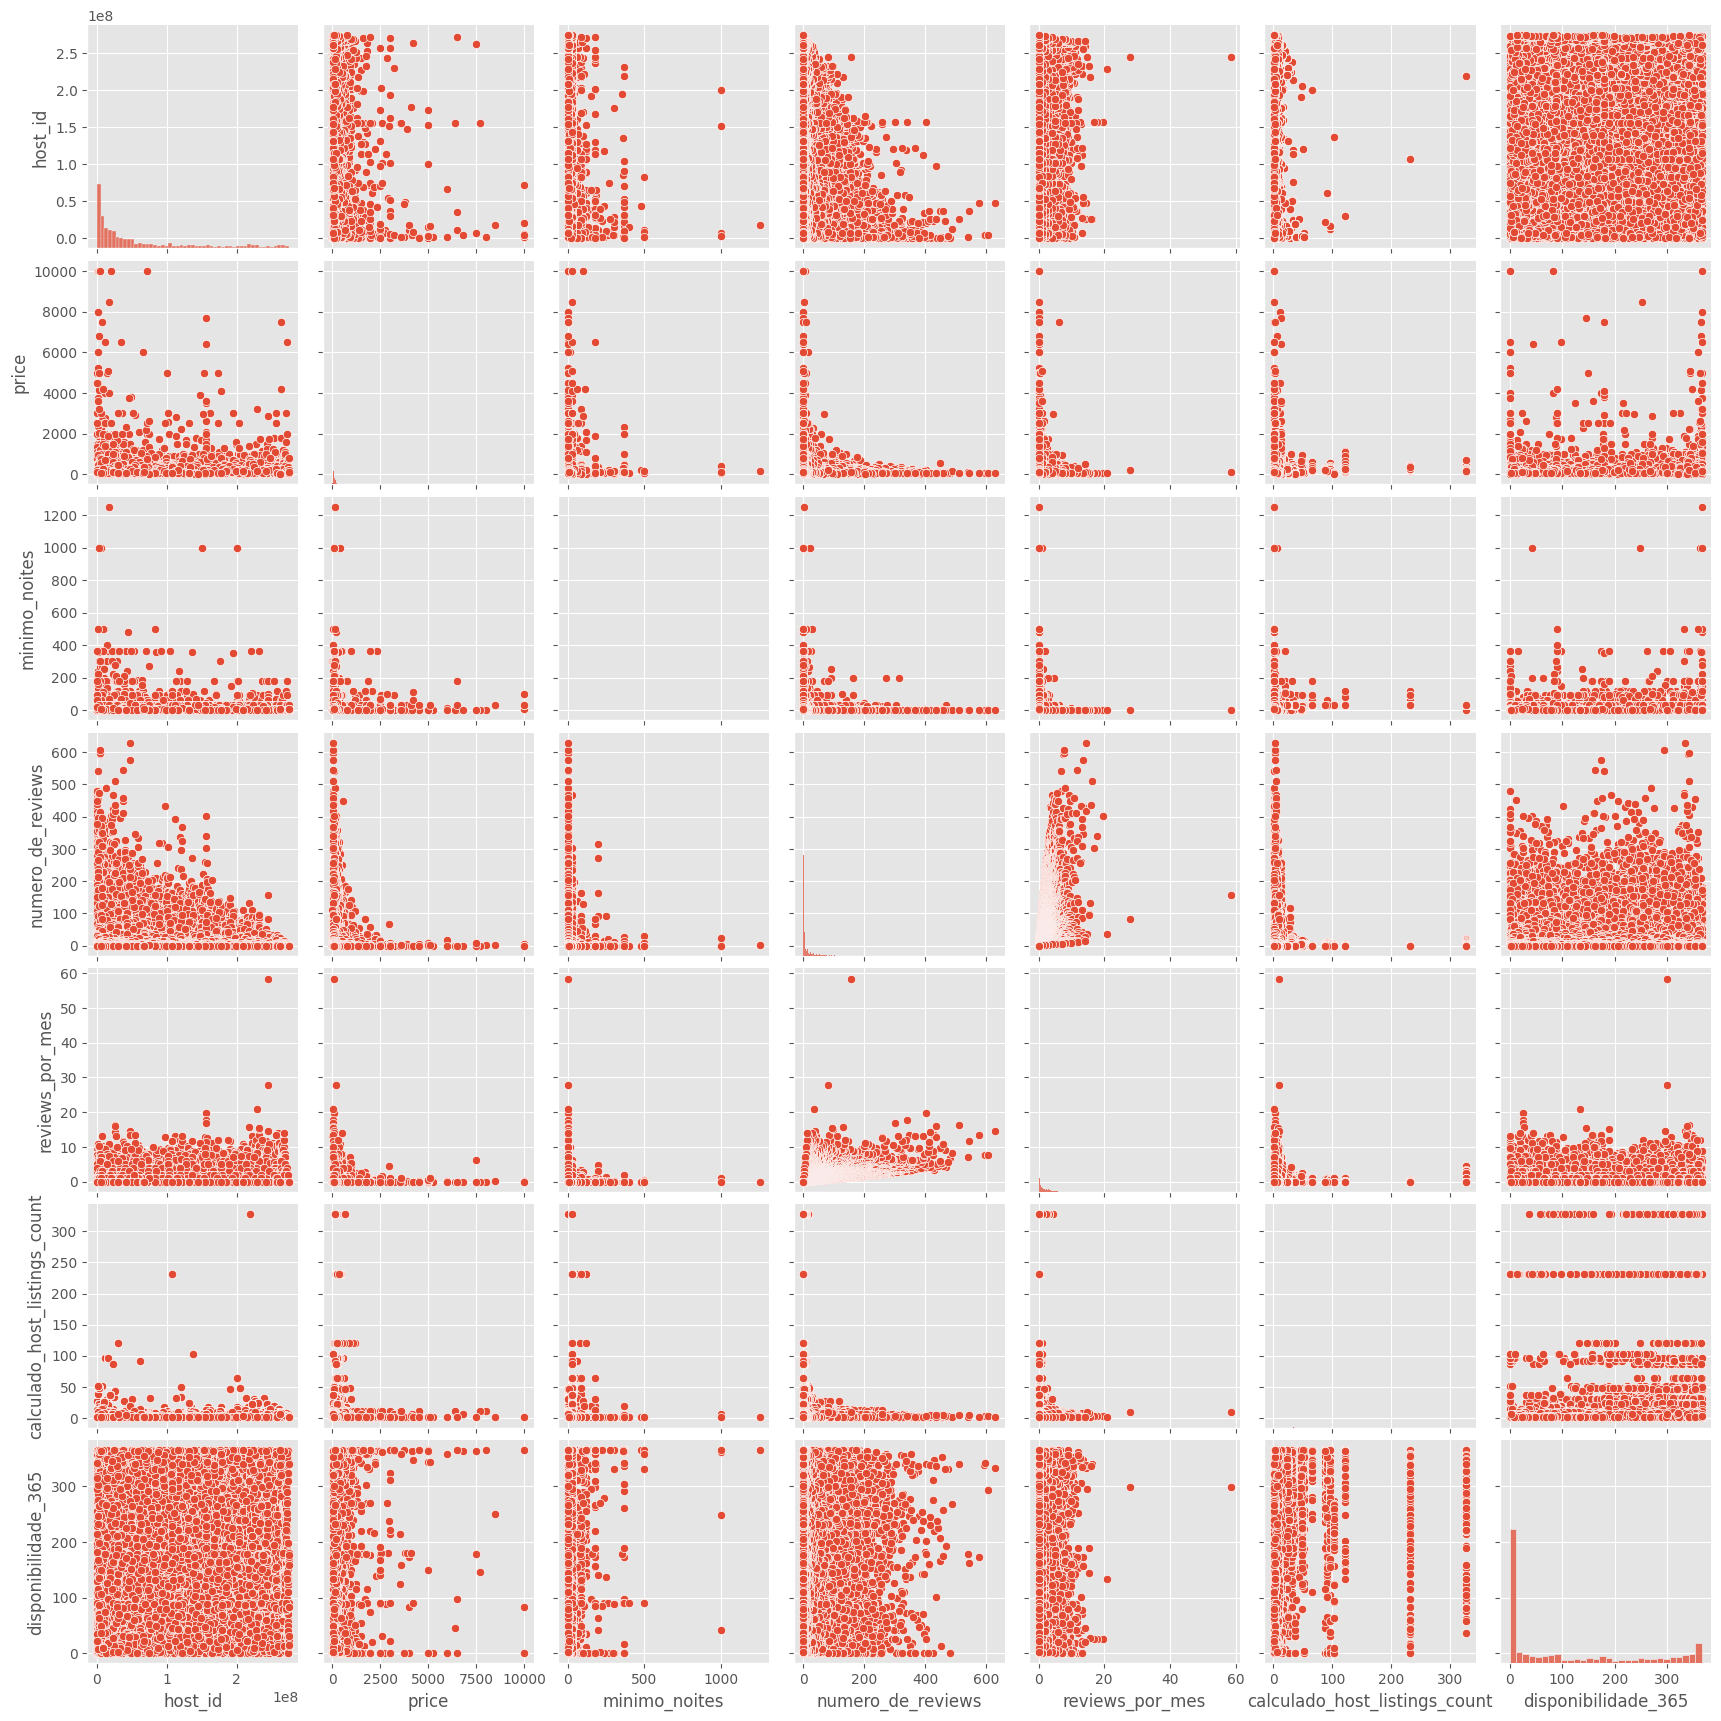

<IPython.core.display.Javascript object>

In [27]:
matplotlib.use('module://ipykernel.pylab.backend_inline')

colunas_analisadas = ['host_id', 'price', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']
sns.pairplot(df2[colunas_analisadas]);

### Análise de palavras nos nomes dos anúncios

Vamos analisar algumas palavras que frequentemente aparecem nos nomes dos anúncios, e comparar os resultados quando analisarmos apenas os anúncios de alto padrão. Aqui, definimos "alto padrão" como aqueles com preço maior do que U$ 500,00 por noite.

In [28]:
stop_words = set(stopwords.words('english'))

# Contando palavras em todos os anúncios
palavras = (
    df2['nome'].dropna().astype(str).str.lower().str.replace(r'[^\w\s]', '')
    .str.split().explode().loc[lambda x: ~x.isin(stop_words)]
)
palavras_filtradas = palavras[palavras.str.len() > 2]
contagem_palavras = palavras_filtradas.value_counts()

percentual_palavras = (
    round(contagem_palavras / len(palavras_filtradas) * 100, 2)
    .apply(lambda x: '{:.2f}%'.format(x)).str.replace('.', ',')
)

palavras_ordenadas = contagem_palavras.sort_values(ascending=False)

<IPython.core.display.Javascript object>

In [29]:
# Contando palavras nos anúncios caros (preço > U$ 500,00)
anuncios_caros = pd.DataFrame(df2).query('price > 500')

palavras_caras = (
    anuncios_caros['nome'].dropna().astype(str).str.lower().str.replace(r'[^\w\s]', '')
    .str.split().explode().loc[lambda x: ~x.isin(stop_words)]
)
palavras_caras_filtradas = palavras_caras[palavras_caras.str.len() > 2]

contagem_palavras_caras = palavras_caras_filtradas.value_counts()

percentual_palavras_caras = (
    round(contagem_palavras_caras / len(palavras_caras_filtradas) * 100, 2)
    .apply(lambda x: '{:.2f}%'.format(x)).str.replace('.', ',')
)

palavras_caras_ordenadas = contagem_palavras_caras.sort_values(ascending=False)                                                              

<IPython.core.display.Javascript object>

In [30]:
lista_palavras = palavras_ordenadas.index.tolist()
lista_palavras_caras = palavras_caras_ordenadas.index.tolist()

contagem_lista = Counter(lista_palavras)
contagem_lista_caras = Counter(lista_palavras_caras)


top30_lista = set(item for item, _ in contagem_lista.most_common(30))
top30_lista_caras = set(item for item, _ in contagem_lista_caras.most_common(30))

valores_comuns = top30_lista.intersection(top30_lista_caras)

valores_exclusivos_list_cara = top30_lista_caras - top30_lista

dados_tabela = []

for palavra in top30_lista_caras:
    posicao_lista_caras = lista_palavras_caras.index(palavra) + 1
    diferenca_rank = (lista_palavras.index(palavra) + 1) - posicao_lista_caras if palavra in lista_palavras else None
    if diferenca_rank < 0:
        str_diferenca_rank = f'Caiu {abs(diferenca_rank)} posições' 
    elif diferenca_rank > 0:
        str_diferenca_rank = f'Subiu {diferenca_rank} posições' 
    elif diferenca_rank == 0:
        str_diferenca_rank = 'Manteve a posição'
        
    dados_tabela.append({'Palavra': palavra, 'Posicao_lista_anuncios_caros': posicao_lista_caras, 'Diferenca_para_lista_geral': str_diferenca_rank})

tabela_diferenca = pd.DataFrame(dados_tabela)

<IPython.core.display.Javascript object>

Tabela mostrando as palavras mais comuns nos anúncios caros (> U$ 500,00), comparando com sua frequência na listagem geral e mostrando a diferença de posições para a lista com todos os anúncios.

In [31]:
# Criando o dataframe com as informações
tabela_combinada = pd.DataFrame({
    'Palavra': contagem_palavras_caras.index,
    'Contagem_anuncios_caros': contagem_palavras_caras.values,
    'Porcentagem_anuncios_caros': percentual_palavras_caras.values,
    'Contagem_geral': contagem_palavras.reindex(contagem_palavras_caras.index, fill_value=0).values,
    'Porcentagem_geral': percentual_palavras.reindex(contagem_palavras_caras.index, fill_value='0,00%').values,
    
})

# Remover strings com comprimento menor do que 2
tabela_combinada = tabela_combinada[tabela_combinada['Palavra'].str.len() > 2]

# Juntar a tabela com a diferença no ranqueamento da lista de palavras caras para a lista geral
tabela_final = pd.merge(tabela_combinada, tabela_diferenca[['Palavra', 'Diferenca_para_lista_geral']], on='Palavra', how='left')

display(tabela_final.head(30))

,Palavra,Contagem_anuncios_caros,Porcentagem_anuncios_caros,Contagem_geral,Porcentagem_geral,Diferenca_para_lista_geral
0,bedroom,127,"2,38%",7228,"3,15%",Subiu 1 posições
1,luxury,121,"2,27%",1614,"0,70%",Subiu 23 posições
2,loft,101,"1,89%",1821,"0,79%",Subiu 17 posições
3,apartment,72,"1,35%",6112,"2,66%",Manteve a posição
4,suite,69,"1,29%",626,"0,27%",Subiu 54 posições
5,townhouse,68,"1,27%",446,"0,19%",Subiu 77 posições
6,apt,66,"1,24%",3570,"1,56%",Subiu 1 posições
7,private,65,"1,22%",6984,"3,04%",Caiu 5 posições
8,manhattan,62,"1,16%",2855,"1,24%",Subiu 2 posições
9,village,61,"1,14%",2055,"0,90%",Subiu 7 posições


<IPython.core.display.Javascript object>

Palavras como *luxury*, *loft*, *townhouse*, *duplex*, *bath*, *suite*, *penthouse* aumentaram muito a frequência de ocorrência em anúncios de alto padrão. No entanto, a maioria são características do próprio imóvel, ou seja, casas/apartamentos com suíte, com dois andares (duplex), townhouses (casas inteiras, o que pode elevar o preço do aluguel).

# Feature Engineering

In [32]:
# Calculando a distância do anúncio até o centro
def calcular_distancia(df):
    anuncio_coordenadas = (df['latitude'], df['longitude'])

    pontos_turisticos={'centro_ny_coordenadas': (40.7128, -74.0060),
                       'central_park_coordenadas': (40.7826, -73.9656),
                       'estatua_liberdade_coordenadas': (40.6892, -74.0445)}

    for ponto, coordenada in pontos_turisticos.items():
        coluna = 'distancia_'+ponto[:-12]
        df[coluna] = geodesic(anuncio_coordenadas, coordenada).kilometers
        
    return df

df3 = df2.copy()
df3 = df3.apply(calcular_distancia, axis=1)
df3.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,distancia_centro_ny,distancia_central_park,distancia_estatua_liberdade
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,1558396800,0.38,2,355,4.906576,3.565150,8.803582
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,-9223372037,0.00,1,365,11.977809,3.550857,15.878529
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1562284800,4.64,1,194,4.970672,10.834050,7.177392
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1542585600,0.10,1,0,10.863385,2.539335,14.812628
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,1561161600,0.59,1,129,4.674671,3.959318,8.754537


<IPython.core.display.Javascript object>

# Modelagem

##### Separação da variável *target* e divisão em treino e teste

In [33]:
# Dividindo em X e y
X = df3.drop('price', axis = 1)
y = df3['price']

<IPython.core.display.Javascript object>

In [34]:
# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

<IPython.core.display.Javascript object>

#### Feature Engineering

In [35]:
train_data = pd.concat([X_train, y_train], axis=1)

# Média do bairro e distrito
media_bairros = train_data.groupby('bairro_group')['price'].mean().reset_index()
media_bairros.rename(columns={'price': 'bairro_group_mean'}, inplace=True)

media_distritos = train_data.groupby('bairro')['price'].mean().reset_index()
media_distritos.rename(columns={'price': 'bairro_mean'}, inplace=True)

X_train = pd.merge(X_train, media_bairros, on='bairro_group', how='left')
X_train = pd.merge(X_train, media_distritos, on='bairro', how='left')
X_test = pd.merge(X_test, media_bairros, on='bairro_group', how='left')
X_test = pd.merge(X_test, media_distritos, on='bairro', how='left')

<IPython.core.display.Javascript object>

##### Instanciação dos modelos

In [36]:
modelo_regressao_linear = LinearRegression(fit_intercept=True)
modelo_decision_tree = DecisionTreeRegressor(random_state = 0, max_depth = 8, min_samples_split = 10)
modelo_XGBoost = XGBRegressor(n_estimators = 1000, max_depth = 8, learning_rate = 1e-3, n_jobs = -1, random_state = 0)
modelo_LightGBM = LGBMRegressor(n_estimators = 1000, max_depth = 8, num_leaves = 2^8, learning_rate = 1e-3, n_jobs = -1, verbose = -1, random_state = 0)
modelo_catboost = CatBoostRegressor(n_estimators = 1000, max_depth = 8, learning_rate = 1e-3, random_state = 0, verbose = 0)

<IPython.core.display.Javascript object>

##### Feature Importance

In [37]:
# Aplicando o Feature importance

# Instanciando o catboost encoder para variáveis categóricas
encoder = CatBoostEncoder()

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

X_train_encoded.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

for col in X_train_encoded.select_dtypes(include=['object']).columns:

    # Tratando a variável categórica
    X_train_encoded[col] = encoder.fit_transform(X_train_encoded[col], y_train)
    X_test_encoded[col] = encoder.transform(X_test_encoded[col])

# Treinando o modelo
modelo_XGBoost.fit(X_train_encoded, y_train)

r = permutation_importance(modelo_XGBoost, X_test_encoded, y_test, n_repeats = 30, random_state = 0)

<IPython.core.display.Javascript object>

In [38]:
# Criando um dataframe para mostrar as importâncias de cada variável
importances = pd.DataFrame({'Feature':X_test_encoded.columns, 'importance':r.importances_mean*100})

# Ordenando as variáveis pela importância
importances = importances.sort_values(by='importance', ascending=False)
importances

,Feature,importance
15,distancia_centro_ny,145.067145
17,distancia_estatua_liberdade,30.124779
19,bairro_mean,15.649443
8,room_type,9.471488
5,bairro,8.112432
16,distancia_central_park,6.110729
9,minimo_noites,5.820265
3,host_name,3.344083
14,disponibilidade_365,3.318190
2,host_id,2.616249


<IPython.core.display.Javascript object>

In [39]:
# Definindo as colunas menos importantes com base no Feature Importance
colunas_menos_importantes = importances[importances['importance'] < 0]['Feature']

# Excluindo as colunas menos importantes
X_train = X_train.drop(columns = colunas_menos_importantes)
X_test = X_test.drop(columns = colunas_menos_importantes)

<IPython.core.display.Javascript object>

In [40]:
# Aplicando o Feature importance

# Instanciando o catboost encoder para variáveis categóricas
encoder = CatBoostEncoder()

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for col in X_train_encoded.select_dtypes(include=['object']).columns:

    # Tratando a variável categórica
    X_train_encoded[col] = encoder.fit_transform(X_train_encoded[col], y_train)
    X_test_encoded[col] = encoder.transform(X_test_encoded[col])

# Treinando o modelo
modelo_XGBoost.fit(X_train_encoded, y_train)

r_versao_2 = permutation_importance(modelo_XGBoost, X_test_encoded, y_test, n_repeats = 30, random_state = 0)

<IPython.core.display.Javascript object>

In [41]:
# Criando um dataframe para mostrar as importâncias de cada variável
importances_2 = pd.DataFrame({'Feature':X_test_encoded.columns, 'importance':r_versao_2.importances_mean*100})

# Ordenando as variáveis pela importância
importances_2 = importances_2.sort_values(by='importance', ascending=False)
importances_2

,Feature,importance
14,distancia_centro_ny,148.650665
16,distancia_estatua_liberdade,37.604956
17,bairro_mean,16.763396
7,room_type,9.973310
5,bairro,8.526467
15,distancia_central_park,5.830029
8,minimo_noites,4.050274
3,host_name,3.965870
13,disponibilidade_365,3.682381
2,host_id,2.547436


<IPython.core.display.Javascript object>

In [42]:
def validacao_cruzada(X, y, modelo, k):
    
    folds = KFold(n_splits = k, shuffle = True, random_state = 42)

    # Criando listas para armazenar os valores das métricas em cada fold
    erros_absolutos = list()
    erros_quadrados = list()
    r2 = list()

    # Será aplicado o método "split" no objeto folds, que retornará uma lista 
    # com os índices das instâncias que pertencem ao conjunto de treino e 
    # outra com os índices das instâncias que pertencem ao conjunto de teste
    for k, (train_index, test_index) in enumerate(folds.split(X, y)):
    
        print("~~"*15 + f" Fold: {k+1} " + "~~"*15)

        # Dividindo os dados em treino e teste para cada um dos folds
        X_train_interno, y_train_interno = X.iloc[train_index, :], y.iloc[train_index]
        X_test_interno, y_test_interno = X.iloc[test_index, :], y.iloc[test_index]
        # train_index e test_index: São os índices das instâncias do conjunto 
        # de treino e teste, respectivamente, selecionados em cada um dos folds
        
        # Instanciando o CatBoost Encoder
        encoder = CatBoostEncoder()

        # Criando um imputer para preencher com a moda os valores faltantes de variáveis categóricas
        cat_imputer = SimpleImputer(strategy='most_frequent')
        
        # Criando um imputer para preencher com a mediana os valores faltantes de variáveis numéricas
        num_imputer = SimpleImputer(strategy='median')

        # Criando pipelines para variáveis categóricas e numéricas que preenche os valores faltantes
        cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
        num_pipeline = Pipeline([('imputer', num_imputer)])

        # Definindo quem s"ao as variãveis num~ericas e categóricas
        cat_cols = X_train_interno.select_dtypes(include=['object']).columns
        num_cols = X_train_interno.select_dtypes(exclude=['object']).columns

        # Aplicando os pipelines no conjunto de treinamento para preencher valores faltantes em colunas categóricas e numéricas
        X_train_interno[cat_cols] = cat_pipeline.fit_transform(X_train_interno[cat_cols], y_train_interno)
        X_train_interno[num_cols] = num_pipeline.fit_transform(X_train_interno[num_cols])

        # Aplicando os pipelines ao conjunto de teste para preencher valores faltantes em colunas categóricas e numéricas
        X_test_interno[cat_cols] = cat_pipeline.transform(X_test_interno[cat_cols])
        X_test_interno[num_cols] = num_pipeline.transform(X_test_interno[num_cols])

        # Treinando o modelo
        modelo.fit(X_train_interno, y_train_interno)

        # Obtendo as previsões do modelo
        y_pred = modelo.predict(X_test_interno)
    
        # Calculando as métricas para o fold em questão
        r2score = r2_score(y_test_interno, y_pred)
        mse = mean_squared_error(y_test_interno, y_pred)
        mae = mean_absolute_error(y_test_interno, y_pred)

        # Armazenando as métricas nas listas criadas
        erros_absolutos.append(mae)
        erros_quadrados.append(mse)
        r2.append(r2score)

        # Exibindo as métricas para cada um dos folds
        print(f"MAE: {mae:.3f}")
        print(f"MSE: {mse:.3f}")
        print(f"R2: {r2score:.3f}")

    # Transformando as listas erros_absolutos, erros_quadrados e r2 em arrays, para fazer operações matemáticas
    erros_absolutos = np.array(erros_absolutos)
    erros_quadrados = np.array(erros_quadrados)
    r2 = np.array(r2)

    # Calculando a média de todas as métricas
    media_mae = np.mean(erros_absolutos)
    media_mse = np.mean(erros_quadrados)
    media_r2 = np.mean(r2)

    # Calculando o desvio padrão de todas as métricas
    std_mae = np.std(erros_absolutos)
    std_mse = np.std(erros_quadrados)
    std_r2 = np.std(r2)
    
    print("#-"*6 + "Exibindo a média das métricas obtidas" + "-#"*6)
    print(f"Média do MAE: {media_mae:.3f} +/- {std_mae:.3f}")
    print(f"Média do MSE: {media_mse:.3f} +/- {std_mse:.3f}")
    print(f"Média do R2: {media_r2:.3f} +/- {std_r2:.3f}")

<IPython.core.display.Javascript object>

##### Modelo Regressão Linear

In [43]:
validacao_cruzada(X, y, modelo_regressao_linear, k=5)

#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
MAE: 71.280
MSE: 51642.430
R2: 0.104
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
MAE: 73.867
MSE: 52539.597
R2: 0.117
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
MAE: 75.569
MSE: 66820.528
R2: 0.117
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
MAE: 72.892
MSE: 51946.565
R2: 0.125
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#
MAE: 71.659
MSE: 29553.412
R2: 0.182
#-#-#-#-#-#-Exibindo a média das métricas obtidas-#-#-#-#-#-#
Média do MAE: 73.053 +/- 1.556
Média do MSE: 50500.506 +/- 11938.818
Média do R2: 0.129 +/- 0.027


<IPython.core.display.Javascript object>

##### Modelo Decision Tree

In [44]:
validacao_cruzada(X, y, modelo_decision_tree, k=5)

#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
MAE: 69.547
MSE: 71320.020
R2: -0.237
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
MAE: 69.217
MSE: 61334.474
R2: -0.031
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
MAE: 70.733
MSE: 69416.108
R2: 0.083
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
MAE: 72.089
MSE: 80298.857
R2: -0.353
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#
MAE: 65.499
MSE: 32566.056
R2: 0.099
#-#-#-#-#-#-Exibindo a média das métricas obtidas-#-#-#-#-#-#
Média do MAE: 69.417 +/- 2.204
Média do MSE: 62987.103 +/- 16362.382
Média do R2: -0.088 +/- 0.179


<IPython.core.display.Javascript object>

##### Modelo XGBoost

In [45]:
validacao_cruzada(X, y, modelo_XGBoost, k=5)

#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
MAE: 68.466
MSE: 52486.229
R2: 0.090
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
MAE: 69.680
MSE: 51805.221
R2: 0.130
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
MAE: 72.487
MSE: 64371.560
R2: 0.149
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
MAE: 70.229
MSE: 52909.114
R2: 0.109
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#
MAE: 67.252
MSE: 27889.323
R2: 0.228
#-#-#-#-#-#-Exibindo a média das métricas obtidas-#-#-#-#-#-#
Média do MAE: 69.623 +/- 1.763
Média do MSE: 49892.289 +/- 11943.775
Média do R2: 0.141 +/- 0.048


<IPython.core.display.Javascript object>

##### Modelo LightGBM

In [46]:
validacao_cruzada(X, y, modelo_LightGBM, k=5)

#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
MAE: 72.054
MSE: 52812.601
R2: 0.084
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
MAE: 72.416
MSE: 52666.479
R2: 0.115
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
MAE: 76.847
MSE: 67959.335
R2: 0.102
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
MAE: 72.765
MSE: 51791.177
R2: 0.128
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#
MAE: 71.170
MSE: 29874.105
R2: 0.173
#-#-#-#-#-#-Exibindo a média das métricas obtidas-#-#-#-#-#-#
Média do MAE: 73.050 +/- 1.971
Média do MSE: 51020.739 +/- 12170.530
Média do R2: 0.120 +/- 0.030


<IPython.core.display.Javascript object>

##### Modelo CatBoost

In [47]:
validacao_cruzada(X, y, modelo_catboost, k=5)

#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
MAE: 69.770
MSE: 52045.152
R2: 0.097
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
MAE: 70.953
MSE: 52266.899
R2: 0.122
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
MAE: 74.859
MSE: 67243.863
R2: 0.111
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
MAE: 71.197
MSE: 51386.425
R2: 0.134
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#
MAE: 69.377
MSE: 29372.674
R2: 0.187
#-#-#-#-#-#-Exibindo a média das métricas obtidas-#-#-#-#-#-#
Média do MAE: 71.231 +/- 1.940
Média do MSE: 50463.002 +/- 12107.925
Média do R2: 0.130 +/- 0.031


<IPython.core.display.Javascript object>

##### Tunagem de Hiperparâmetros

In [57]:
def tunagem_hiperparametros(trial, k=5):

    # Tunagem 
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1, step=0.1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)

    folds = KFold(n_splits = k, shuffle = True, random_state = 42)

    # Criando listas para armazenar os valores das métricas em cada fold
    erros_absolutos = list()
    erros_quadrados = list()
    r2 = list()

    # Será aplicado o método "split" no objeto folds, que retornará uma lista 
    # com os índices das instâncias que pertencem ao conjunto de treino e 
    # outra com os índices das instâncias que pertencem ao conjunto de teste
    
    for k, (train_index, test_index) in enumerate(folds.split(X, y)):
        
        
        
        print("~~"*15 + f" Fold: {k+1} " + "~~"*15)

        # Dividindo os dados em treino e teste para cada um dos folds
        X_train_interno, y_train_interno = X.iloc[train_index, :], y.iloc[train_index]
        X_test_interno, y_test_interno = X.iloc[test_index, :], y.iloc[test_index]
        # train_index e test_index: São os índices das instâncias do conjunto 
        # de treino e teste, respectivamente, selecionados em cada um dos folds

        # Instanciando o CatBoost Encoder
        encoder = CatBoostEncoder()

        # Criando um imputer para preencher com a moda os valores faltantes de variáveis categóricas
        cat_imputer = SimpleImputer(strategy='most_frequent')

        # Criando um imputer para preencher com a mediana os valores faltantes de variáveis numéricas
        num_imputer = SimpleImputer(strategy='median')

        # Criando pipelines para variáveis categóricas e numéricas que preenche os valores faltantes
        cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
        num_pipeline = Pipeline([('imputer', num_imputer)])

        # cat_cols e num_cols são trazidos para cá para incluir as novas variáveis criadas no feature engineering
        cat_cols = X_train_interno.select_dtypes(include=['object']).columns
        num_cols = X_train_interno.select_dtypes(exclude=['object']).columns

        # Aplicando os pipelines no conjunto de treinamento para preencher valores faltantes em colunas categóricas e numéricas
        X_train_interno[cat_cols] = cat_pipeline.fit_transform(X_train_interno[cat_cols], y_train_interno)
        X_train_interno[num_cols] = num_pipeline.fit_transform(X_train_interno[num_cols])

        # Aplicando os pipelines ao conjunto de teste para preencher valores faltantes em colunas categóricas e numéricas
        X_test_interno[cat_cols] = cat_pipeline.transform(X_test_interno[cat_cols])
        X_test_interno[num_cols] = num_pipeline.transform(X_test_interno[num_cols])

        # Treinando o modelo
        modelo_XGBoost.fit(X_train_interno, y_train_interno)

        # Obtendo as previsões do modelo
        y_pred = modelo_XGBoost.predict(X_test_interno)
    
        # Calculando as métricas para o fold em questão
        r2score = r2_score(y_test_interno, y_pred)
        mse = mean_squared_error(y_test_interno, y_pred)
        mae = mean_absolute_error(y_test_interno, y_pred)

        # Armazenando as métricas nas listas criadas
        erros_absolutos.append(mae)
        erros_quadrados.append(mse)
        r2.append(r2score)


    # Transformando as listas erros_absolutos, erros_quadrados e r2 em arrays, para fazer operações matemáticas
    erros_absolutos = np.array(erros_absolutos)
    erros_quadrados = np.array(erros_quadrados)
    r2 = np.array(r2)

    # Calculando a média de todas as métricas
    media_mae = np.mean(erros_absolutos)
    media_mse = np.mean(erros_quadrados)
    media_r2 = np.mean(r2)

    # Calculando o desvio padrão de todas as métricas
    std_mae = np.std(erros_absolutos)
    std_mse = np.std(erros_quadrados)
    std_r2 = np.std(r2)

    return media_mse

study = opt.create_study(direction='minimize')
study.optimize(tunagem_hiperparametros, n_trials = 10)

[I 2024-02-09 21:34:43,602] A new study created in memory with name: no-name-1397bdc6-224d-430c-9c94-cefd144487cf


~~~~~~~~~~~~~~~~Fold: 1~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 2~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 3~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 4~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 5~~~~~~~~~~~~~~~~


[I 2024-02-09 21:34:59,851] Trial 0 finished with value: 49892.28940706406 and parameters: {'learning_rate': 0.0514882809254223, 'max_depth': 10, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 1}. Best is trial 0 with value: 49892.28940706406.


~~~~~~~~~~~~~~~~Fold: 1~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 2~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 3~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 4~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 5~~~~~~~~~~~~~~~~


[I 2024-02-09 21:35:16,438] Trial 1 finished with value: 49892.28940706406 and parameters: {'learning_rate': 0.0785998728213528, 'max_depth': 1, 'subsample': 0.8, 'colsample_bytree': 0.5, 'min_child_weight': 6}. Best is trial 0 with value: 49892.28940706406.


~~~~~~~~~~~~~~~~Fold: 1~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 2~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 3~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 4~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 5~~~~~~~~~~~~~~~~


[I 2024-02-09 21:35:32,869] Trial 2 finished with value: 49892.28940706406 and parameters: {'learning_rate': 0.033250921087704804, 'max_depth': 10, 'subsample': 0.9, 'colsample_bytree': 0.8, 'min_child_weight': 7}. Best is trial 0 with value: 49892.28940706406.


~~~~~~~~~~~~~~~~Fold: 1~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 2~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 3~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 4~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 5~~~~~~~~~~~~~~~~


[I 2024-02-09 21:35:50,231] Trial 3 finished with value: 49892.28940706406 and parameters: {'learning_rate': 0.008902499473625139, 'max_depth': 7, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 5}. Best is trial 0 with value: 49892.28940706406.


~~~~~~~~~~~~~~~~Fold: 1~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 2~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 3~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 4~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 5~~~~~~~~~~~~~~~~


[I 2024-02-09 21:36:07,737] Trial 4 finished with value: 49892.28940706406 and parameters: {'learning_rate': 0.0016629707794203448, 'max_depth': 7, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 5}. Best is trial 0 with value: 49892.28940706406.


~~~~~~~~~~~~~~~~Fold: 1~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 2~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 3~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 4~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 5~~~~~~~~~~~~~~~~


[I 2024-02-09 21:36:25,456] Trial 5 finished with value: 49892.28940706406 and parameters: {'learning_rate': 0.006677144073261689, 'max_depth': 6, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 6}. Best is trial 0 with value: 49892.28940706406.


~~~~~~~~~~~~~~~~Fold: 1~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 2~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 3~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 4~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 5~~~~~~~~~~~~~~~~


[I 2024-02-09 21:36:42,654] Trial 6 finished with value: 49892.28940706406 and parameters: {'learning_rate': 0.001083165148745406, 'max_depth': 8, 'subsample': 0.9, 'colsample_bytree': 0.6, 'min_child_weight': 2}. Best is trial 0 with value: 49892.28940706406.


~~~~~~~~~~~~~~~~Fold: 1~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 2~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 3~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 4~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 5~~~~~~~~~~~~~~~~


[I 2024-02-09 21:37:02,982] Trial 7 finished with value: 49892.28940706406 and parameters: {'learning_rate': 0.0013047258949375337, 'max_depth': 5, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 7}. Best is trial 0 with value: 49892.28940706406.


~~~~~~~~~~~~~~~~Fold: 1~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 2~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 3~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 4~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 5~~~~~~~~~~~~~~~~


[I 2024-02-09 21:37:20,746] Trial 8 finished with value: 49892.28940706406 and parameters: {'learning_rate': 0.0019235968658736918, 'max_depth': 8, 'subsample': 0.9, 'colsample_bytree': 0.8, 'min_child_weight': 6}. Best is trial 0 with value: 49892.28940706406.


~~~~~~~~~~~~~~~~Fold: 1~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 2~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 3~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 4~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~Fold: 5~~~~~~~~~~~~~~~~


[I 2024-02-09 21:37:38,202] Trial 9 finished with value: 49892.28940706406 and parameters: {'learning_rate': 0.07222557149704802, 'max_depth': 2, 'subsample': 1.0, 'colsample_bytree': 0.5, 'min_child_weight': 7}. Best is trial 0 with value: 49892.28940706406.


<IPython.core.display.Javascript object>

In [58]:
params = {'learning_rate': 0.07222557149704802, 'max_depth': 2, 'subsample': 1.0, 'colsample_bytree': 0.5, 'min_child_weight': 7}

<IPython.core.display.Javascript object>

##### Modelo Tunado

In [59]:
modelo_escolhido = XGBRegressor(n_estimators = 1000, n_jobs=-1, random_state=0, **params)

<IPython.core.display.Javascript object>

In [60]:
validacao_cruzada(X, y, modelo_XGBoost, k=10)

#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
MAE: 69.823
MSE: 63994.178
R2: 0.074
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
MAE: 66.531
MSE: 41035.925
R2: 0.112
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
MAE: 67.307
MSE: 31677.304
R2: 0.189
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
MAE: 71.143
MSE: 70301.962
R2: 0.121
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#
MAE: 72.615
MSE: 65487.588
R2: 0.127
#-#-#-#-#-#-#-#-Fold: 6-#-#-#-#-#-#-#-#
MAE: 74.058
MSE: 67281.116
R2: 0.119
#-#-#-#-#-#-#-#-Fold: 7-#-#-#-#-#-#-#-#
MAE: 70.389
MSE: 59122.945
R2: 0.075
#-#-#-#-#-#-#-#-Fold: 8-#-#-#-#-#-#-#-#
MAE: 69.299
MSE: 42875.884
R2: 0.218
#-#-#-#-#-#-#-#-Fold: 9-#-#-#-#-#-#-#-#
MAE: 65.579
MSE: 19022.674
R2: 0.269
#-#-#-#-#-#-#-#-Fold: 10-#-#-#-#-#-#-#-#
MAE: 69.040
MSE: 37289.940
R2: 0.194
#-#-#-#-#-#-Exibindo a média das métricas obtidas-#-#-#-#-#-#
Média do MAE: 69.578 +/- 2.515
Média do MSE: 49808.952 +/- 16784.938
Média do R2: 0.150 +/- 0.061


<IPython.core.display.Javascript object>

## Exportação do modelo final

In [61]:
caminho_arquivo_pkl = 'modelo_final_lh_cd_paulo.pkl'

with open(caminho_arquivo_pkl, 'wb') as arquivo:
    pickle.dump(modelo_escolhido, arquivo)

<IPython.core.display.Javascript object>

## Teste com dados fornecidos
{\'id\': 2595,

\'nome\': \'Skylit Midtown Castle\',

\'host_id\': 2845,

\'host_name\': \'Jennifer\',

\'bairro_group\': \'Manhattan\',

\'bairro\': \'Midtown\',

\'latitude\': 40.75362,

\'longitude\': -73.98377,

\'room_type\': \'Entire home/apt\',

\'price\': 225,

\'minimo_noites\': 1,

\'numero_de_reviews\': 45,

\'ultima_review\': \'2019-05-21\',

\'reviews_por_mes\': 0.38,

\'calculado_host_listings_count\': 2,

\'disponibilidade_365\': 355}

In [72]:
caracteristicas_exemplo = {'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'price': 225,
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}

df_caracteristicas = pd.DataFrame(caracteristicas_exemplo, index=[0])
df_caracteristicas

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


<IPython.core.display.Javascript object>

In [73]:
df_caracteristicas = df_caracteristicas.apply(calcular_distancia, axis=1)

df_caracteristicas = pd.merge(df_caracteristicas, media_bairros, on='bairro_group', how='left')
df_caracteristicas = pd.merge(df_caracteristicas, media_distritos, on='bairro', how='left')

df_caracteristicas['ultima_review'] = pd.to_datetime(df_caracteristicas['ultima_review'], errors='coerce')
df_caracteristicas['ultima_review'] = df_caracteristicas['ultima_review'].astype('int64') // 10**9

df_caracteristicas

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,distancia_centro_ny,distancia_central_park,distancia_estatua_liberdade,bairro_group_mean,bairro_mean
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,1558396800,0.38,2,355,4.906576,3.56515,8.803582,197.661075,280.305505


<IPython.core.display.Javascript object>

In [74]:
X_train_exemplo = X_train.copy()
y_train_exemplo = y_train.copy()

X_test_exemplo = df_caracteristicas[X_train_exemplo.columns]
y_test_exemplo = df_caracteristicas['price']

# Carregar o modelo do arquivo .pkl
with open('modelo_final_lh_cd_paulo.pkl', 'rb') as arquivo:
    modelo_carregado = pickle.load(arquivo)

encoder = CatBoostEncoder()

cat_imputer = SimpleImputer(strategy='most_frequent')

num_imputer = SimpleImputer(strategy='median')

cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
num_pipeline = Pipeline([('imputer', num_imputer)])

cat_cols = X_train_exemplo.select_dtypes(include=['object']).columns
num_cols = X_train_exemplo.select_dtypes(exclude=['object']).columns

X_train_exemplo.reset_index(drop=True, inplace=True)
y_train_exemplo.reset_index(drop=True, inplace=True)

X_train_exemplo[cat_cols] = cat_pipeline.fit_transform(X_train_exemplo[cat_cols], y_train_exemplo)
X_train_exemplo[num_cols] = num_pipeline.fit_transform(X_train_exemplo[num_cols])

X_test_exemplo[cat_cols] = cat_pipeline.transform(X_test_exemplo[cat_cols])
X_test_exemplo[num_cols] = num_pipeline.transform(X_test_exemplo[num_cols])


<IPython.core.display.Javascript object>

In [75]:

modelo_carregado.fit(X_train_exemplo, y_train_exemplo)

preco_predito = modelo_carregado.predict(X_test_exemplo)

def formatar_preco(preco):
    preco_formatado = 'U$ {:,.2f}'.format(preco[0]).replace(',', 'v').replace('.', ',').replace('v', '.')
    return preco_formatado

print(f'''Preço predito: {formatar_preco(preco_predito)}
Preço pré-estabelecido no exemplo: {formatar_preco(y_test_exemplo)}''')

Preço predito: U$ 281,46
Preço pré-estabelecido no exemplo: U$ 225,00


<IPython.core.display.Javascript object>

### Preço sugerido pelo modelo:
##### **U$ 278,81**

# Respostas às perguntas de negócio
### 1. Onde seria mais indicada a compra de um apartamento para aluguel na plataforma?

A pergunta é um pouco ampla e **depende** de muitos fatores. Padrão do imóvel, **Manhattan** possui os preços mais elevados, mas ao mesmo tempo pode ser difícil dado a alta concentração de anfitriões com muitos imóveis, gerando uma espécie de oligopólio. Seria interessante, baseado na *feature importance* realizada na modelagem, imóveis próximos a pontos turísticos, visto que estão bastante relacionados ao preço de um aluguel.

### 2.	O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

São variáveis que interferem sim, mas de maneira mediana. Variáveis como **bairro**, **tipo de espaço** e **proximidade de pontos importantes da cidade** acabam interferindo de forma mais significativa no preço.

### 3.  Existe algum padrão no texto do nome do local para lugares de mais alto valor?

Conforme exposto durante a análise, palavras como ***luxury***, ***loft***, ***townhouse***, ***duplex***, ***bath***, ***suite***, ***penthouse*** aumentaram muito a frequência de ocorrência em anúncios de alto padrão. No entanto, a maioria são características do próprio imóvel, ou seja, casas/apartamentos com suíte, com dois andares (duplex), townhouses (casas inteiras, o que pode elevar o preço do aluguel), apenas descrevendo características *premium* dos imóveis.